In [131]:
import pandas as pd 
import tensorflow as tf 
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

False

In [98]:
img_size = 256
batcH_size = 32
channels = 3
epochs = 50

In [99]:
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\devth\Documents\VScode_files\DL_fullstack_project_potato_health\PlantVillage',
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = batcH_size,
)

Found 2152 files belonging to 3 classes.


In [100]:
class_names = data_set.class_names

print(class_names) # folder names are your class names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [101]:
len(data_set)

68

In [102]:
for image_batch, label_batch in data_set.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    
for image_batch, label_batch in data_set.take(1):
    print(image_batch[0].numpy().shape)


(32, 256, 256, 3)
[1 0 2 0 1 1 0 1 0 0 1 0 1 0 2 2 0 0 1 1 2 0 0 1 2 0 1 1 1 0 1 0]
(256, 256, 3)


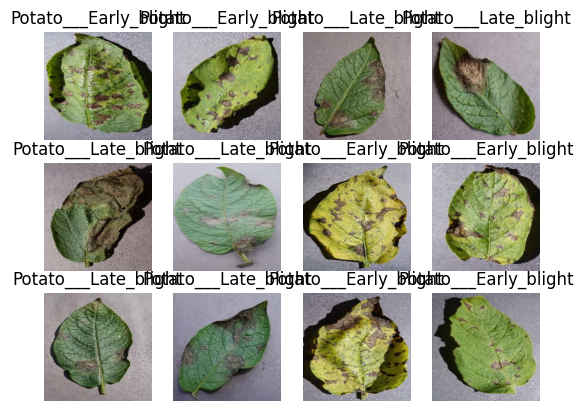

In [103]:
#imshow expects 3d arrays 

for image_batch, label_batch in data_set.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')


In [104]:
len(data_set)

68

In [105]:
# 80 percent as triaining data and the rest as testing data
# of which 10 percent will be used for validation during the training process and the rest will be used for testing 

train_size = 0.8
len(data_set)*train_size



54.400000000000006

In [106]:
train_ds = data_set.take(54) # take the first 54 data as training data 
len(train_ds)

54

In [107]:
test_ds = data_set.skip(54) # skip the first 54 and take the rest of the data 
len(test_ds)

14

In [108]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [109]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [110]:
# compiling all these small code snippets into one function 

def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shufffle_size= 10000):
    ds_size = len(ds)
    
    if shuffle : 
        ds = ds.shuffle(shufffle_size,seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [111]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(data_set)

In [91]:
len(train_ds)

54

In [92]:
len(test_ds)

8

In [93]:
len(val_ds)

6

In [94]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [95]:
resize_and_rescale = tf.keras.Sequential([
    # incase if we supply an image that is not of this dimension itll help us
    layers.Resizing(img_size,img_size),
    layers.Rescaling(1.0/255)
])

In [96]:
# data augmentation 

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_vertical"),
    layers.RandomRotation(0.2)
])

In [113]:
# using convolutional neural network to build the model 
input_shape = (batcH_size,img_size,img_size,channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

c:\Users\devth\Documents\VScode_files\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [114]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [137]:
history = model.fit(
    train_ds,
    epochs = epochs,
    batch_size = batcH_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 668ms/step - accuracy: 0.9977 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 715ms/step - accuracy: 0.9952 - loss: 0.0134 - val_accuracy: 0.9688 - val_loss: 0.0451
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 729ms/step - accuracy: 0.9962 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 710ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 693ms/step - accuracy: 0.9967 - loss: 0.0092 - val_accuracy: 0.9948 - val_loss: 0.0351
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 694ms/step - accuracy: 0.9888 - loss: 0.0396 - val_accuracy: 0.9948 - val_loss: 0.0248
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 632ms/step - accuracy: 0.9951 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 624ms/step - accuracy: 0.9961 - loss: 0.0108 - val_accu

In [139]:
scores = model.evaluate(test_ds)
scores 

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 1.0000 - loss: 1.2546e-04


[0.0002986416220664978, 1.0]

In [140]:
print(history)
print(history.params)
print(history.history.keys())
history.history['accuracy']

{'verbose': 1, 'epochs': 50, 'steps': 54}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


[0.9970657229423523,
 0.9958920478820801,
 0.9976525902748108,
 1.0,
 0.9930555820465088,
 0.9907407164573669,
 0.9976525902748108,
 0.9923709034919739,
 0.9964788556098938,
 0.9982638955116272,
 1.0,
 0.9988425970077515,
 0.9964788556098938,
 0.9900234937667847,
 0.9900234937667847,
 0.9924768805503845,
 0.9941314458847046,
 0.9907407164573669,
 0.9794601202011108,
 0.9888497591018677,
 0.9958920478820801,
 0.9947183132171631,
 0.9976525902748108,
 0.9994131326675415,
 1.0,
 1.0,
 0.9994131326675415,
 0.9994131326675415,
 0.96772301197052,
 0.9835680723190308,
 0.9895833134651184,
 0.998826265335083,
 0.9970657229423523,
 0.9994131326675415,
 0.998826265335083,
 0.9982638955116272,
 0.9994212985038757,
 0.9982394576072693,
 0.9917840361595154,
 0.9917840361595154,
 0.9964788556098938,
 0.9964788556098938,
 0.9994131326675415,
 0.998826265335083,
 0.9994131326675415,
 0.9994131326675415,
 0.9976851940155029,
 0.9988425970077515,
 1.0,
 0.9988425970077515]

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

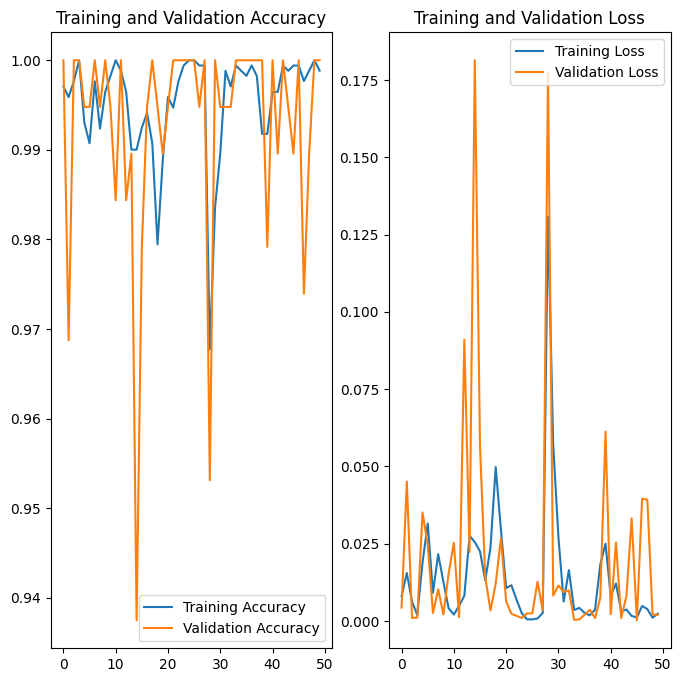

In [142]:
# plotting for overfitting and underfitting

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first images actual label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
predicted labels :  Potato___Late_blight


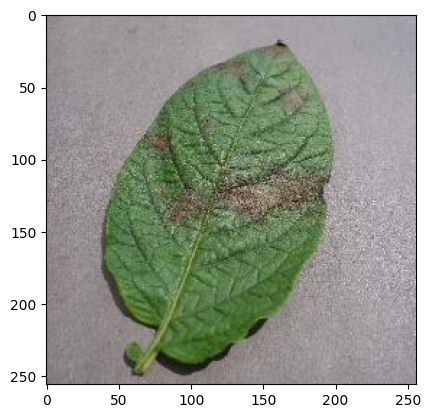

In [143]:
import numpy as np

for images_batch , labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print('first image to predict')
    plt.imshow(first_image)
    print("first images actual label : ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    
    print('predicted labels : ', class_names[np.argmax(batch_prediction[0])])

In [144]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


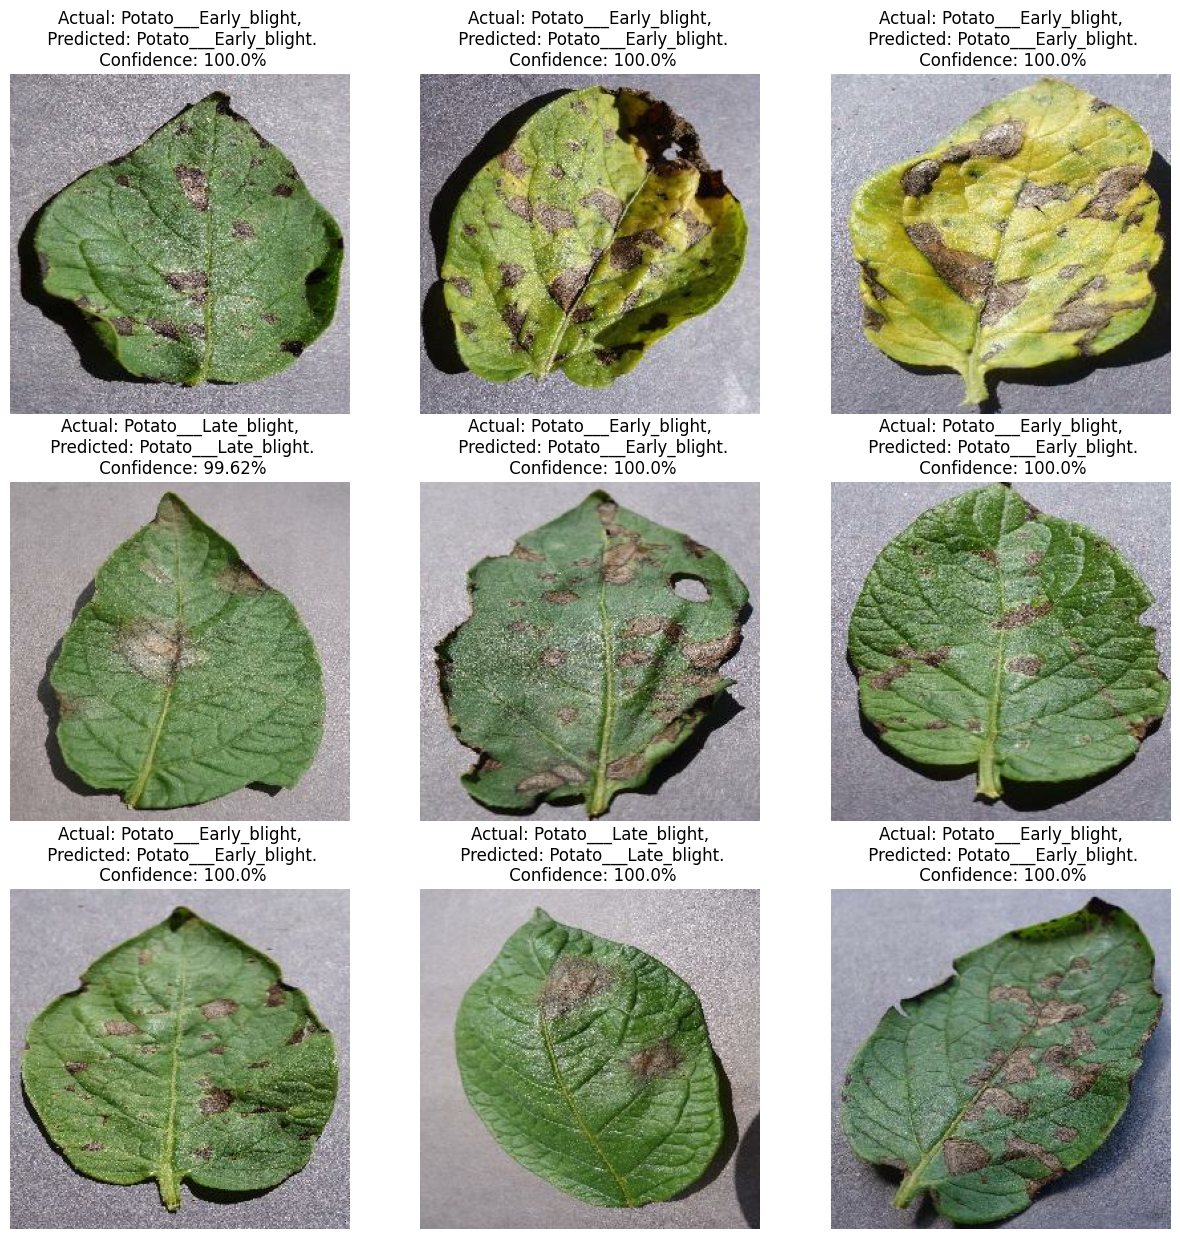

In [145]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [151]:
import os
import tensorflow as tf

# Define the folder to save models
model_dir = r"DL_fullstack_project_potato_health\models"
os.makedirs(model_dir, exist_ok=True)

# Get existing model versions in the folder
existing_models = [f for f in os.listdir(model_dir) if f.startswith("model_v") and f.endswith(".h5")]

# Determine next version number
def get_next_version(existing_models):
    versions = [int(f.split("_v")[1].split(".h5")[0]) for f in existing_models if "_v" in f]
    next_version = max(versions) + 1 if versions else 1
    return next_version

# Example model (replace with your actual model)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

# Save the model with versioning
next_version = get_next_version(existing_models)
model_path = os.path.join(model_dir, f"model_v{next_version}.h5")
model.save(model_path)
print(f"Model saved to {model_path}")


Model saved to DL_fullstack_project_potato_health\models\model_v2.h5
